<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/local-dev/00_base_pop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MIMIC-CXR 2.0.0 Dataset Processing**

The MIMIC-CXR 2.0.0 dataset contains approximately 4.7 TB of compressed DICOM files.
We will not process the entire dataset. Instead, we'll focus on a targeted subset by filtering only the Anteroposterior (AP) view X-rays that are relevant to this project.


## Approach
We'll implement a systematic workflow to:

*   Filter the dataset to identify only AP view X-rays using the report files
*   Download a manageable subset of these AP view DICOM files.

In [101]:
# Import necessary libraries
import os
import pandas as pd
import pydicom
import numpy as np
import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import sys
import random
base_path = "/Users/simeon/Documents/DLH/content/mimic-cxr-project"
sys.path.append(f"{base_path}/modules")


In [102]:
# Define base path
base_path = "/Users/simeon/Documents/DLH/content/mimic-cxr-project"
sys.path.append(f"{base_path}/modules")
from report_parser import parse_report, MIMIC_RE

In [103]:
# Function to check if a DICOM file exists and is AP view
def is_ap_view_dicom(subject_id, study_id, dicom_id):
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_dir = f"s{study_id}"
    dicom_file = f"{dicom_id}.dcm"
    dicom_path = os.path.join(base_path, 'new_files', subject_prefix, subject_dir, study_dir, dicom_file)

    if not os.path.exists(dicom_path):
        return False

    try:
        plan = pydicom.dcmread(dicom_path, stop_before_pixels=True)
        return hasattr(plan, 'ViewPosition') and plan.ViewPosition == 'AP'
    except:
        return False

In [104]:
# Function to check if a report has a findings section
def has_findings_section(subject_id, study_id):
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_dir = f"s{study_id}"
    report_file = f"{study_dir}.txt"
    report_path = os.path.join(base_path, 'reports', 'files', subject_prefix, subject_dir, report_file)

    if not os.path.exists(report_path):
        return False

    try:
        with open(report_path, 'r') as f:
            report_text = f.read().lower()
        return 'findings' in report_text
    except:
        return False

In [105]:
# Load original CSV files
record_list_path = os.path.join(base_path, 'cxr-record-list.csv')
study_list_path = os.path.join(base_path, 'cxr-study-list.csv')

df_studies = pd.read_csv(study_list_path)
df_records = pd.read_csv(record_list_path)

print(f"Original studies: {df_studies.shape[0]}")
print(f"Original records: {df_records.shape[0]}")

# Merge dataframes
df = pd.merge(
    df_studies[['subject_id', 'study_id']],
    df_records[['subject_id', 'study_id', 'dicom_id']],
    on=['subject_id', 'study_id']
)

print(f"Original merged dataframe: {df.shape[0]} rows")

Original studies: 227835
Original records: 377110
Original merged dataframe: 377110 rows


In [106]:
# Filter for AP view DICOM files and reports with findings sections
filtered_rows = []
for _, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    subject_id = row['subject_id']
    study_id = row['study_id']
    dicom_id = row['dicom_id']

    # Check if DICOM is AP view and report has findings section
    if is_ap_view_dicom(subject_id, study_id, dicom_id) and has_findings_section(subject_id, study_id):
        filtered_rows.append(row)

100%|██████████| 377110/377110 [00:14<00:00, 25231.37it/s]


In [107]:
# Create filtered dataframe
filtered_df = pd.DataFrame(filtered_rows)
print(f"Filtered dataframe (AP views with findings): {filtered_df.shape[0]} rows")

# Create record list with available AP view DICOMs
available_records = filtered_df[['subject_id', 'study_id', 'dicom_id']].copy()
available_records['dicom_is_available'] = True

# Create study list with unique study IDs
available_studies = filtered_df[['subject_id', 'study_id']].drop_duplicates()

# Save the filtered CSV files
available_records.to_csv(os.path.join(base_path, 'available-cxr-record-list.csv'), index=False)
available_studies.to_csv(os.path.join(base_path, 'available-cxr-study-list.csv'), index=False)

print(f"Created available-cxr-record-list.csv with {available_records.shape[0]} records")
print(f"Created available-cxr-study-list.csv with {available_studies.shape[0]} studies")

# Print stats
print(f"Unique subjects: {available_records['subject_id'].nunique()}")
print(f"Unique studies: {available_records['study_id'].nunique()}")
print(f"Unique AP view DICOMs: {available_records['dicom_id'].nunique()}")

Filtered dataframe (AP views with findings): 6737 rows
Created available-cxr-record-list.csv with 6737 records
Created available-cxr-study-list.csv with 6080 studies
Unique subjects: 3459
Unique studies: 6080
Unique AP view DICOMs: 6737


In [108]:
# Create train/test split based on subjects
# Create a dict to organize data by subject
data_by_subject = defaultdict(list)
for _, row in filtered_df.iterrows():
    subject_id = row['subject_id']
    study_id = row['study_id']
    dicom_id = row['dicom_id']

    # Generate paths for convenience
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_dir = f"s{study_id}"
    dicom_file = f"{dicom_id}.dcm"
    dicom_path = os.path.join(base_path, 'new_files', subject_prefix, subject_dir, study_dir, dicom_file)
    report_file = f"{study_dir}.txt"
    report_path = os.path.join(base_path, 'reports', 'files', subject_prefix, subject_dir, report_file)

    data_by_subject[subject_id].append((dicom_path, report_path, dicom_id, study_id))

In [109]:


# Get list of subject IDs
subject_ids = list(data_by_subject.keys())
random.seed(42)  # For reproducibility
random.shuffle(subject_ids)

# Split 70% train, 30% test
split_idx = int(0.7 * len(subject_ids))
train_subjects = subject_ids[:split_idx]
test_subjects = subject_ids[split_idx:]

# Create data directory if it doesn't exist
data_dir = os.path.join(base_path, 'data')
os.makedirs(data_dir, exist_ok=True)

# Prepare train/test dataframes
train_rows = []
for subject_id in train_subjects:
    for dicom_path, report_path, dicom_id, study_id in data_by_subject[subject_id]:
        train_rows.append({
            'subject_id': subject_id,
            'study_id': study_id,
            'dicom_id': dicom_id
        })

test_rows = []
for subject_id in test_subjects:
    for dicom_path, report_path, dicom_id, study_id in data_by_subject[subject_id]:
        test_rows.append({
            'subject_id': subject_id,
            'study_id': study_id,
            'dicom_id': dicom_id
        })

train_df = pd.DataFrame(train_rows)
test_df = pd.DataFrame(test_rows)

# Save train/test splits
train_df.to_csv(os.path.join(data_dir, 'train.tsv'), sep='\t', index=False)
test_df.to_csv(os.path.join(data_dir, 'test.tsv'), sep='\t', index=False)

print(f"Saved {len(train_df)} training samples to data/train.tsv")
print(f"Saved {len(test_df)} test samples to data/test.tsv")
print(f"Train subjects: {len(train_subjects)}")
print(f"Test subjects: {len(test_subjects)}")

Saved 4796 training samples to data/train.tsv
Saved 1941 test samples to data/test.tsv
Train subjects: 2421
Test subjects: 1038


10000032 (2)
	-----------
	Patient ID: 10000032
	View Position: AP


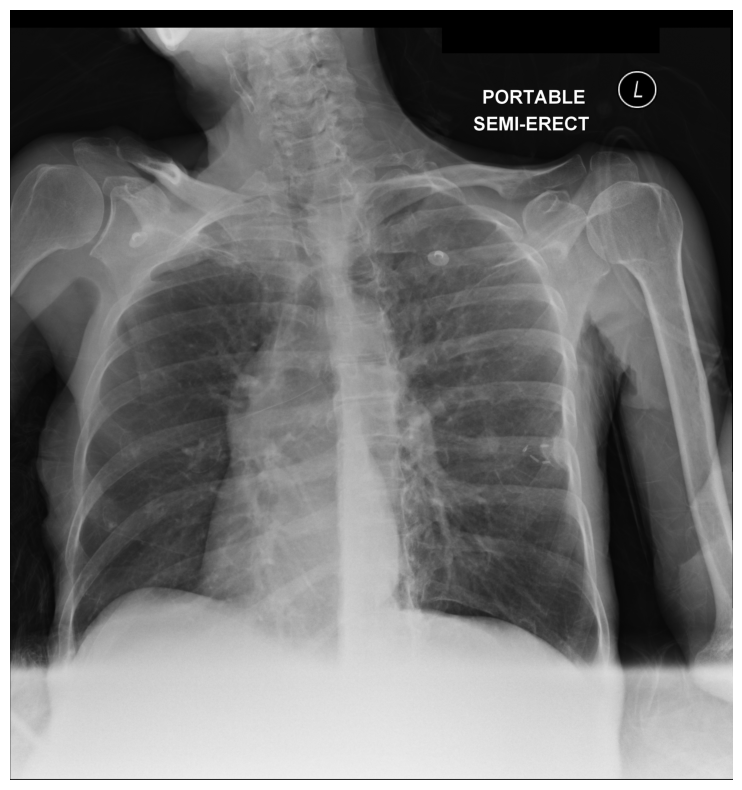

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.
	-----------
	Patient ID: 10000032
	View Position: AP


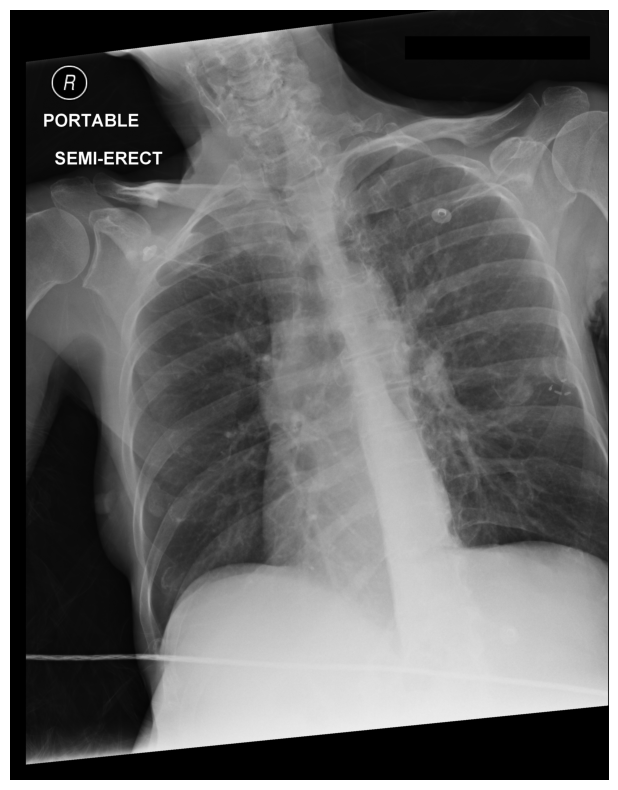

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.

10000935 (1)
	-----------
	Patient ID: 10000935
	View Position: AP


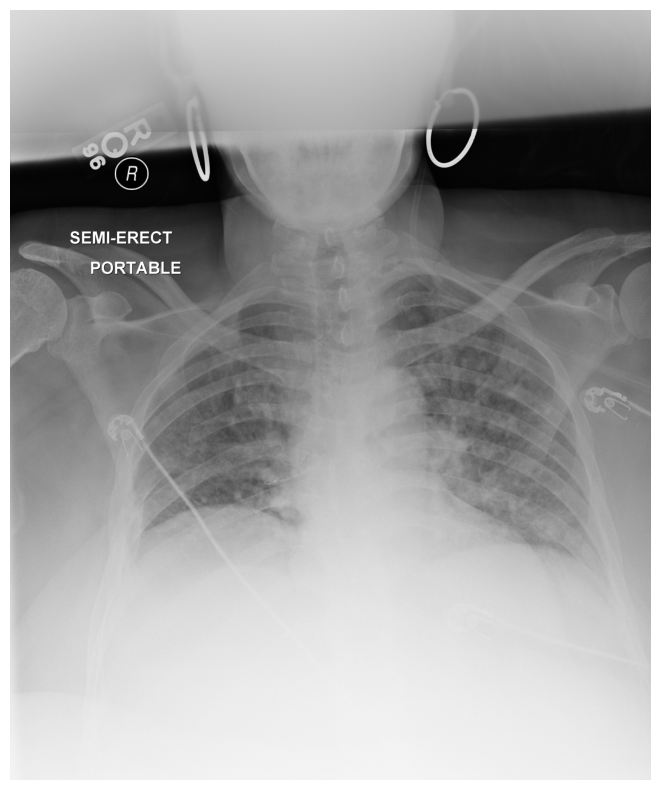

	Findings: lung volumes are low. this results in crowding of the bronchovascular structures. there may be mild pulmonary vascular congestion. the heart size is borderline enlarged. the mediastinal and hilar contours are relatively unremarkable. innumerable nodules are demonstrated in both lungs, more pronounced in the left upper and lower lung fields compatible with metastatic disease. no new focal consolidation, pleural effusion or pneumothorax is seen, with chronic elevation of right hemidiaphragm again seen. the patient is status post right lower lobectomy. rib deformities within the right hemithorax is compatible with prior postsurgical changes.

10001401 (1)
	-----------
	Patient ID: 10001401
	View Position: AP


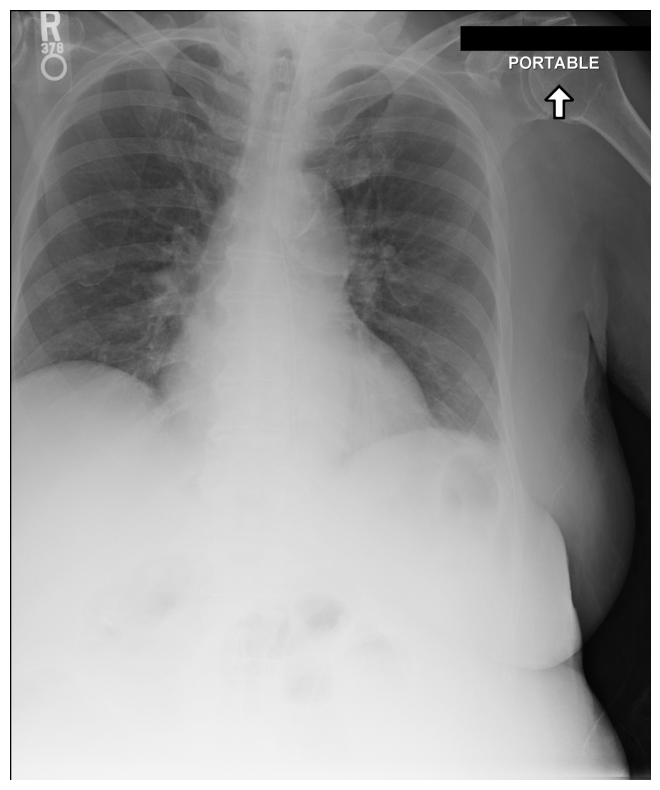

	Findings: the right costophrenic angle is not imaged. otherwise, the lungs are clear. the heart size is upper limits of normal. enteric tube courses below the level of the diaphragm. there is no pneumothorax.



In [110]:
# Convert data_by_subject to a format compatible with the spot-check code
data = {}
for subject_id, items_list in data_by_subject.items():
    data[subject_id] = [(dicom_path, report_path) for dicom_path, report_path, _, _ in items_list]

# Load a few images to spot check
n = min(3, len(data))
first_n = dict(list(data.items())[:n])

for subject_id, items in first_n.items():
    print(f'{subject_id} ({len(items)})')

    for j, (dicom_path, report_path) in enumerate(items[:2]):  # Show up to 2 images per patient
        try:
            # Read DICOM file
            plan = pydicom.dcmread(dicom_path)

            # Convert to image
            pixel_array = plan.pixel_array
            image = Image.fromarray(np.uint8(pixel_array/pixel_array.max()*255))

            # Parse report
            parsed_report = parse_report(report_path)

            # Display information
            print('\t-----------')
            print('\tPatient ID:', plan.PatientID if hasattr(plan, 'PatientID') else 'Unknown')
            print('\tView Position:', plan.ViewPosition if hasattr(plan, 'ViewPosition') else 'Unknown')

            plt.figure(figsize=(10, 10))
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()

            if 'findings' in parsed_report:
                print("\tFindings:", parsed_report['findings'])
            else:
                print('\tFindings: None')

        except Exception as e:
            print(f"\tError processing {dicom_path}: {e}")

    print('\t===================================================')
    print()